<a href="https://colab.research.google.com/github/AndreassOlsson/faceID/blob/main/SiameseNN_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import tarfile
import itertools
import functools
import operator

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from fastai.vision.all import get_image_files, parent_label, Path, show_image

## Load data

In [ ]:
path = "drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lfw-dfun-extracted-nm.tgz" 
tarfile.open(path, 'r:gz').extractall('dfun')

In [ ]:
root = Path('dfun/dfun_e/')
subdirs = list(root.ls())
people = list(set(filter(lambda folder: len(folder.ls()) > 1, subdirs)))
people = list(map(lambda x: get_image_files(x), people))
people = list(itertools.chain.from_iterable([[j for j in i] for i in people]))
classes = list(set(map(lambda x: parent_label(x), people)))
cls2idx = {cls:idx for idx,cls in enumerate(classes)}

### Split data

In [ ]:
np.random.seed(420)
idxs = np.random.permutation(len(classes)); 
split1 = int(0.7*len(classes))
split2 = int(0.95*len(classes))

train = [(fname, cls2idx[parent_label(fname)]) for fname in people if parent_label(fname) in list(np.array(classes)[idxs[:split1]])]
valid = [(fname, cls2idx[parent_label(fname)]) for fname in people if parent_label(fname) in list(np.array(classes)[idxs[split1:split2]])]
test = [(fname, cls2idx[parent_label(fname)]) for fname in people if parent_label(fname) in list(np.array(classes)[idxs[split2:]])]
len(train), len(valid), len(test)

(6369, 2407, 386)

## Model

### Simple model

In [ ]:
class SiameseNetwork(nn.Module):
  def __init__(self, version=None):
    super(SiameseNetwork, self).__init__()

    self.cnn1 = nn.Sequential(
        nn.Conv2d(1,32,3),
        nn.BatchNorm2d(32),
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
        # Currently 45x55x32
        nn.Conv2d(32,64,3),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
        #Currently 21x26x64
        nn.Conv2d(64,64,3),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
        #Currently 9x12x64
    )

    self.fc1 = nn.Sequential(
      nn.Linear(20736, 4096), # 43264 for 224x224 images
      nn.Sigmoid(),
      nn.Dropout(0.5,False),
      nn.Linear(4096,512)
    )
  
  def forward_once(self, input):
    output = self.cnn1(input)
    output = output.view(output.size(0), -1)
    output = self.fc1(output)
    return output

  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2


Why do you have just two numbers to represent an image in the end? shouldn't there be more? Also wouldn't it be a good idea to use autoencoders to create another model to recreate the initial image from the last representative outputs..? So that we could improve the  model into one that yields a more representative final representation array.

### Resnet based model

In [ ]:
"""
ResNet is based on the possiblity to skip over cnn blocks, solving the vanishing gradient problem.
We do this by passing an optional parameter (downsample) to trigger our skip connection.
If downsample = True, we apply directly to the input, x, instead of the output, out.
"""
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
      super(ResidualBlock, self).__init__()

      self.conv1 = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU())
      
      self.conv2 = nn.Sequential(
          nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_channels))
      
      self.downsample = downsample
      self.relu = nn.ReLU()
      self.out_channels = out_channels
  
  def forward(self, x):
      residual = x
      out = self.conv1(x)
      out = self.conv2(out)
      if self.downsample: 
        residual = self.downsample(x)
      out += residual
      out = self.relu(out)
      return out

**ResidualBlock**

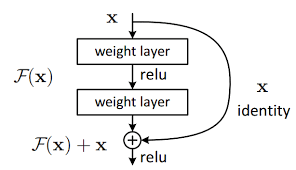

In [ ]:
"""
There are 4 blocks containing 3,4,6 and 3 layers respectivly. To simplify implementation, 
we create a _make_layer function that adds the layers one by one w.t.h. of our ResBlock.
After creating all the blocks, we add average pooling and the final layer. 
"""
class BResNet(nn.Module):
  def __init__(self, resblock, layers):
      super(BResNet, self).__init__()
      self.inplanes = 64
      self.conv1 = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU())
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.l1 = self._make_layer(resblock, 64, layers[0], stride=1)
      self.l2 = self._make_layer(resblock, 128, layers[1], stride=2)
      self.l3 = self._make_layer(resblock, 256, layers[2], stride=2)
      self.l4 = self._make_layer(resblock, 512, layers[3], stride=2)
      self.avgpool = nn.AvgPool2d(7, stride=1)
      self.fc = nn.Linear(512, 512)
      

  def _make_layer(self, block, planes, num_blocks, stride=1):
      downsample = None
      if stride != 1 or self.inplanes != planes:
        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, planes, kernel_size=1, stride = stride),
            nn.BatchNorm2d(planes))
      
      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample))
      self.inplanes = planes
      for i in range(1, num_blocks):
        layers.append(block(self.inplanes, planes))
      
      return nn.Sequential(*layers)

  
  def forward_once(self, x):
      x = self.conv1(x)
      x = self.maxpool(x)
      x = self.l1(x)
      x = self.l2(x)
      x = self.l3(x)
      x = self.l4(x)

      x = self.avgpool(x)
      x = x.view(x.size(0), -1)
      return self.fc(x)

  def forward(self, input1, input2):
      output1 = self.forward_once(input1)
      output2 = self.forward_once(input2)
      return output1, output2 

**34-layer ResNet architecture**

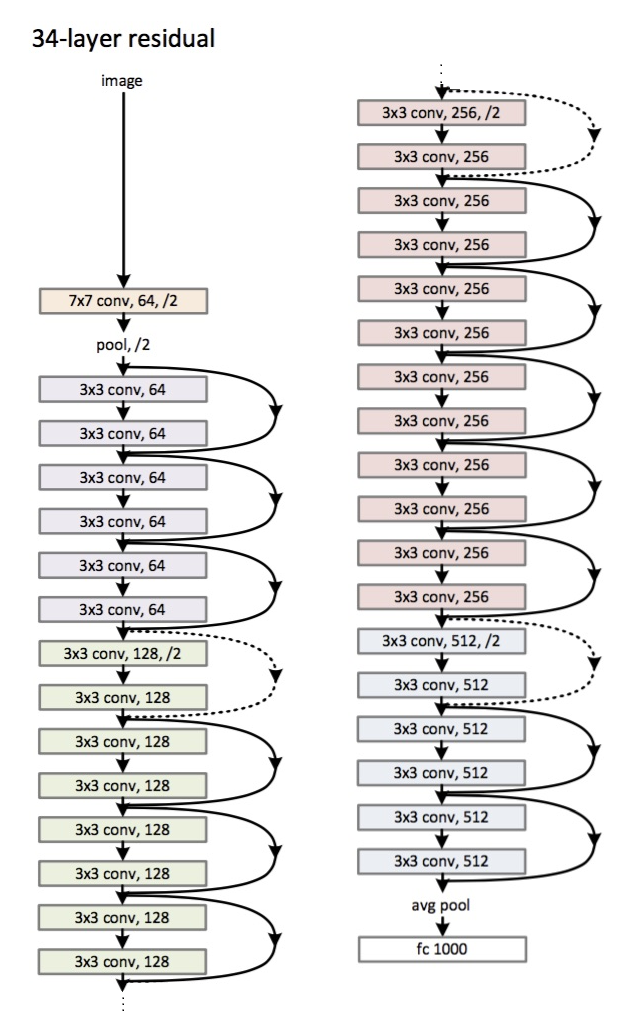

## Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

## Instanciate model & Network variables

In [ ]:
bs = 64
lr = 1e-5
margin = 1.5
epochs = 10

In [ ]:
model = BResNet(ResidualBlock, [3, 6, 11, 3])
if torch.cuda.is_available():
  model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8)
loss_func = ContrastiveLoss(margin)

## Dataset

In [ ]:
"Have the option to duplicate examples"
class SiameseDataset(Dataset):
  def __init__(self, files, dup=False, transforms=None):
    self.dup, self.transforms = dup, transforms

    if self.dup: self.files = list(itertools.chain.from_iterable([[f,f] for f in files]))
    else: self.files = files

    self.cls2files = {cls: [tup[0] for tup in self.files if tup[1] == cls] for _, cls in self.files}

  def __getitem__(self, idx):
    f, cls = self.files[idx]
    if self.dup: same = idx % 2 == 0
    else: same = random.randint(0,1) > 0

    if not same: cls = random.choice([f for f in list(self.cls2files.keys()) if f != cls])
    f2 = random.choice(list(self.cls2files[cls]))

    im = Image.open(f).convert("L")
    im2 = Image.open(f2).convert("L")

    if self.transforms is not None:
      im = self.transforms(im)
      im2 = self.transforms(im2)

    return im, im2, torch.tensor(int(same), dtype=torch.float32)

  def __len__(self): return len(self.files)

In [ ]:
train_trans = transforms.Compose([
          transforms.RandomHorizontalFlip(),
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          transforms.Normalize((0.5), (0.5))])

test_trans = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          transforms.Normalize((0.5), (0.5))])

train_dset = SiameseDataset(train, transforms=train_trans)
valid_dset = SiameseDataset(valid, transforms=test_trans)
test_dset = SiameseDataset(test, transforms=test_trans)

train_dl = DataLoader(train_dset, batch_size=bs)
valid_dl = DataLoader(valid_dset, batch_size=bs)
test_dl = DataLoader(test_dset, batch_size=bs)

## Training

In [ ]:
print(f"{'-'*10} Training started with bs={bs}, lr={lr}, margin={margin}, epochs={epochs} {'-'*10}")

train_loss = []
valid_loss = []
min_valid_loss = np.inf

for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
    for i,(input1,input2,target) in enumerate(train_dl):

        optimizer.zero_grad()
        
        if torch.cuda.is_available():
          output1, output2 = model(input1.cuda(), input2.cuda())
          loss = loss_func(output1,output2,target.cuda())
        else:
          output1, output2 = model(input1, input2)
          loss = loss_func(output1,output2,target)
      
        train_epoch_loss += loss.item()

        loss.backward()

        optimizer.step()
    
    train_epoch_loss /= len(train_dset)
    train_loss.append(train_epoch_loss)
    print("\nEpoch [{}/{}] ----> Training loss :{}".format(epoch+1,epochs,train_epoch_loss))
    
    with torch.no_grad():
      valid_epoch_loss = 0
      model.eval()
      for i, (input1, input2, target) in enumerate(valid_dl):

          output1, output2 = model(input1.cuda(), input2.cuda())

          loss = loss_func(output1, output2, target.cuda())

          valid_epoch_loss += loss.item()

      valid_epoch_loss /= len(valid_dset)
      valid_loss.append(valid_epoch_loss)
      print("Epoch [{}/{}] ----> Validation loss :{}".format(epoch+1,epochs,valid_epoch_loss))


      if min_valid_loss > valid_epoch_loss:
          print(f'Validation Loss Decreased ({min_valid_loss:.4f}--->{valid_epoch_loss:.4f}) \t Saving The Model')
          min_valid_loss = valid_epoch_loss
          torch.save(model.state_dict(), '/content/drive/MyDrive/Andreas Olsson/FastAI/faceID/models/nondup_224_gray_siamese.pth')

---------- Training started with bs=64, lr=1e-05, margin=1.5, epochs=10 ----------

Epoch [1/10] ----> Training loss :0.059414034268604865
Epoch [1/10] ----> Validation loss :0.043518348407784985
Validation Loss Decreased (inf--->0.0435) 	 Saving The Model

Epoch [2/10] ----> Training loss :0.026491479880021044
Epoch [2/10] ----> Validation loss :0.020481684864632164
Validation Loss Decreased (0.0435--->0.0205) 	 Saving The Model

Epoch [3/10] ----> Training loss :0.012776048923890133
Epoch [3/10] ----> Validation loss :0.013307864308406765
Validation Loss Decreased (0.0205--->0.0133) 	 Saving The Model

Epoch [4/10] ----> Training loss :0.010094303709686897
Epoch [4/10] ----> Validation loss :0.012028050189895851
Validation Loss Decreased (0.0133--->0.0120) 	 Saving The Model

Epoch [5/10] ----> Training loss :0.00958039283677573
Epoch [5/10] ----> Validation loss :0.011611669500388196
Validation Loss Decreased (0.0120--->0.0116) 	 Saving The Model

Epoch [6/10] ----> Training loss :0

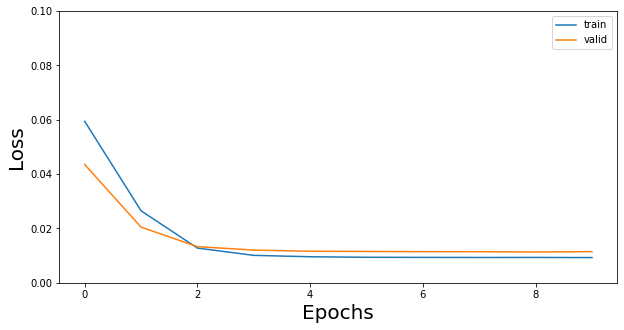

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs",size = 20)
plt.ylabel("Loss", size = 20)
plt.ylim(0,0.1)
plt.legend()
plt.show()

## Inference

In [ ]:
model_path = Path('/content/drive/MyDrive/Andreas Olsson/FastAI/faceID/models/nondup_224_gray_siamese.pth')
model = BResNet(ResidualBlock, [3, 6, 11, 3])

if torch.cuda.is_available():
  model.load_state_dict(torch.load(model_path))
  model = model.cuda()
else: 
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

In [ ]:
def show_tup(tup, pred=None):
  title, target = None, None
  if len(tup) > 2: img1, img2, target = tup
  else: img1, img2 = tup

  if pred and target is not None: title=f"Distance: {pred.item():.4f}, Target: {'Similar' if bool(int(target.item())) else 'Not Similar'}"
  if pred and target is None: title=f"Distance: {pred.item():.4f}"

  if not isinstance(img1, torch.Tensor):
    if not img2.size == img1.size: img2.resize(img1.size)
    t1, t2 = torch.tensor(img1), torch.tensor(img2)
    t1, t2 = t1.permute(2,0,1), t2.permute(2,0,1)
  else: t1, t2 = img1, img2
  line_divider = t1.new_zeros(t1.shape[0], t2.shape[1], 5)
  return show_image(torch.cat([t1,line_divider,t2], dim=2), title=title, cmap='gray')

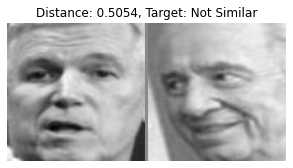

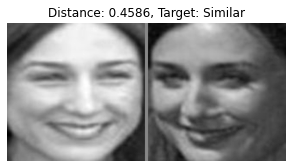

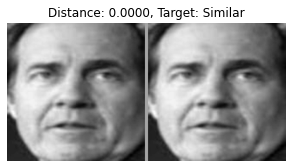

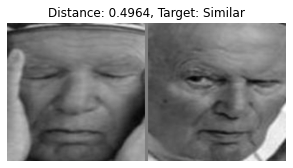

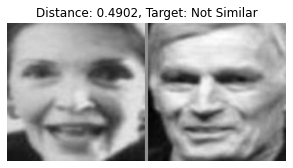

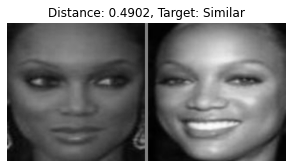

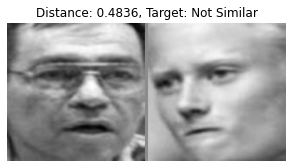

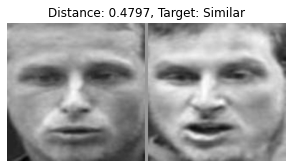

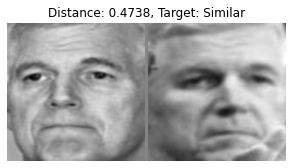

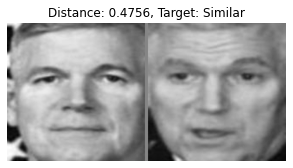

In [ ]:
n = 10
with torch.no_grad():
  for i in range(n):
    idx = np.random.randint(0, len(test_dset))
    input1, input2, target = test_dset[idx]
    output1, output2 = model(input1.cuda().unsqueeze(0), input2.cuda().unsqueeze(0))

    euclidean_distance = F.pairwise_distance(output1, output2)

    show_tup((input1,input2,target), euclidean_distance)